# Geodata Attack - Using GPS

In [1]:
import skmob
from sklearn.cluster import DBSCAN
from skmob.utils import constants
from skmob.utils import utils

from geopy.distance import distance
import pandas as pd
import numpy as np
import csv
import folium

## Preprocessing GPS Data

### Load data from file

In [2]:
gps = '../../privamov/privamov-gps'
gsm = '../../privamov/privamov-gsm'
december = '../../privamov/sorted_december_random'
wifi = '../../privamov/privamov-wifi'

Loading only a subset of data from `privamov-gps.csv` , by using `MAX_LINES` and `SKIP_LINES`

In [3]:
def formatGPS(file, MAX_LINES = 10**7, SKIP_LINES = 50):
    ids = []
    horodate = []
    lat = []
    long = []
    i = 0
    t = 0
    with open(file) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter='\t', quotechar="'")
        for row in csv_reader:
            if t == SKIP_LINES:
                ids.append(row[0])
                horodate.append(row[1])
                lat.append(row[3])
                long.append(row[2])
                if i > MAX_LINES : 
                    break
                t=0
            else :
                t+=1
            i+=1
        d = { 'ID': ids, 'Horodate':horodate, 'Latitude':lat, 'Longitude':long}  
        df = pd.DataFrame(data=d)
    return df

### Build DataFrame & Quick Visualization

In [4]:
df_gps = formatGPS(december,MAX_LINES=943400, SKIP_LINES=0)
df_gps.head()

ID                 Horodate          Latitude         Longitude
0  1  2014-12-01 04:38:09.288  45.7701433333333  4.86983333333333
1  1  2014-12-01 09:46:33.934  45.7708983333333           4.86651
2  1  2014-12-01 09:46:38.927  45.7708366666667  4.86645666666667
3  1   2014-12-01 09:46:43.95  45.7708383333333           4.86621
4  1  2014-12-01 09:46:49.104  45.7708233333333          4.866125

Aggregating number of points by IDs

In [5]:
def get_unique_id(df):
    ids = df['ID']
    unique_id = set()
    for ident in ids:
        unique_id.add(ident)
    return unique_id  

In [6]:
unique_id = sorted(list(get_unique_id(df_gps)))
print(unique_id)

['1', '11', '13', '14', '15', '16', '17', '19', '2', '20', '21', '22', '23', '24', '25', '44', '5', '6', '7', '8']


In [7]:
agg = df_gps.groupby('ID').size().reset_index(name='counts')
agg.sort_values(by='counts',ascending=False).head()

ID  counts
0    1  146565
8    2   85367
11  22   69469
6   17   67618
19   8   66955

## Sampling the Data

```
def sample_by_id(file, ident='1'):
    with open(file, 'r') as i, open('subsamples/privamov_gps_id_{}.csv'.format(ident), 'w', newline='') as o:
        r = csv.reader(i, delimiter='\t')
        w = csv.writer(o, delimiter='\t')
        for row in r:
            if row[0] == ident:
                w.writerow(row)
```

```
sample_by_id(gps,'2')
```

### Build SKMOB Object & Visualize trajectories

In [8]:
tdf = skmob.TrajDataFrame(df_gps, latitude='Latitude', longitude='Longitude', datetime='Horodate', user_id='ID')
tdf.head()

uid                datetime        lat       lng
0   1 2014-12-01 04:38:09.288  45.770143  4.869833
1   1 2014-12-01 09:46:33.934  45.770898  4.866510
2   1 2014-12-01 09:46:38.927  45.770837  4.866457
3   1 2014-12-01 09:46:43.950  45.770838  4.866210
4   1 2014-12-01 09:46:49.104  45.770823  4.866125

In [9]:
print("number of users:\t", len(tdf.uid.unique()))
print("number of records:\t", len(tdf))

number of users:	 20
number of records:	 943402


## Filtering

Filter out all points with speed higher than `max_speed` km/h from the previous point.

In [10]:
from skmob.preprocessing import filtering

In [11]:
ftdf = filtering.filter(tdf, max_speed_kmh=400.)

Very few points have been filtered.

In [12]:
print('Points of the raw trajectory: %s'%len(tdf))
print('Points of the filtered trajectory: %s'%len(ftdf))

Points of the raw trajectory: 943402
Points of the filtered trajectory: 938097


## Compression

Reduce the number of points of the trajectory, preserving the structure.

Merge together all points that are closer than `spatial_radius_km`=0.2 kilometers from each other.

In [13]:
from skmob.preprocessing import compression

In [14]:
ctdf = compression.compress(ftdf, spatial_radius_km=0.2)
ctdf[:4]

uid                datetime        lat       lng
0   1 2014-12-01 04:38:09.288  45.770143  4.869833
1   1 2014-12-01 09:46:33.934  45.770690  4.865407
2   1 2014-12-01 09:59:13.923  45.760030  4.860470
3   1 2014-12-01 10:04:16.971  45.759023  4.860529

The compressed trajectory has only a small fraction of the points of the filtered trajectory (less than 10%)

In [15]:
print('Points of the filtered trajectory: %s'%len(ftdf))
print('Points of the compressed trajectory: %s'%len(ctdf))

Points of the filtered trajectory: 938097
Points of the compressed trajectory: 11600


## Stop detection

Identify locations where the user spent at least minutes_for_a_stop minutes within a `distance spatial_radius_km` $\times$ `stop_radius_factor`, from a given point.

A new column `leaving_datetime` is added, indicating the time when the user departs from the stop.

In [16]:
from skmob.preprocessing import detection

In [17]:
stdf = detection.stops(ctdf, stop_radius_factor=1, \
            minutes_for_a_stop=30, spatial_radius_km=0.5, 
                       leaving_time=True)
stdf[:4]

uid                datetime        lat       lng            leaving_datetime
0   1 2014-12-01 04:38:09.288  45.770143  4.869833  2014-12-01 09:46:33.934000
1   1 2014-12-01 10:37:43.944  45.785832  4.879213  2014-12-01 11:29:40.936000
2   1 2014-12-01 11:32:56.936  45.786388  4.879777  2014-12-01 13:35:01.937000
3   1 2014-12-01 13:40:46.003  45.786410  4.879838  2014-12-01 17:20:19.714000

**Visualise the compressed trajectory and the stops**

Click on the stop markers to see a pop up with:

* User ID
* Coordinates of the stop (click to see the location on Google maps)
* Arrival time
* Departure time

In [18]:
map_f = ctdf.plot_trajectory(max_points=1, hex_color=-1, start_end_markers=False)
stdf.plot_stops(map_f=map_f, hex_color=-1)

## Clustering stops

Stops are clustered by spatial proximity using DBSCAN.

The new column cluster is added to the Stops TrajectoryDataFrame, where the value correspond to the cluster ID each stop belong to.

Clusters IDs are integers (0, 1, ...): 0 is the most visited cluster, 1 is the second most visited, ...

In [19]:
from skmob.preprocessing import clustering

In [20]:
cstdf = clustering.cluster(stdf, cluster_radius_km=0.2, min_samples=1)
cstdf

uid                datetime        lat       lng        leaving_datetime  \
0     1 2014-12-01 04:38:09.288  45.770143  4.869833 2014-12-01 09:46:33.934   
1     1 2014-12-01 10:37:43.944  45.785832  4.879213 2014-12-01 11:29:40.936   
2     1 2014-12-01 11:32:56.936  45.786388  4.879777 2014-12-01 13:35:01.937   
3     1 2014-12-01 13:40:46.003  45.786410  4.879838 2014-12-01 17:20:19.714   
4     1 2014-12-01 17:41:39.286  45.786486  4.879813 2014-12-01 18:43:43.285   
..   ..                     ...        ...       ...                     ...   
379   8 2014-12-10 18:38:09.016  44.840073 -0.571013 2014-12-10 22:40:31.022   
380   8 2014-12-10 22:40:31.022  44.841245 -0.573355 2014-12-11 00:08:34.234   
381   8 2014-12-11 00:08:34.234  44.842047 -0.576130 2014-12-11 09:18:57.351   
382   8 2014-12-11 09:29:54.361  44.849782 -0.571265 2014-12-11 15:36:56.766   
383   8 2014-12-11 15:41:47.523  44.843076 -0.575032 2014-12-11 17:09:23.904   

     cluster  
0          1  
1          0  
2          0  
3          0  
4          0  
..       ...  
379        5  
380        4  
381        2  
382        3  
383        2  

[384 rows x 6 columns]

In [21]:
import DBSCAN

In [22]:
df = DBSCAN.ST_DBSCAN(stdf)
df

/home/abdelaziz/Desktop/Folder/INSA Lyon/5IF/Systèmes et algorithmes répartis/tp attaque/Mobility-Analysis/DBSCAN.py:29: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(index, 'cluster', NOISE)
/home/abdelaziz/Desktop/Folder/INSA Lyon/5IF/Systèmes et algorithmes répartis/tp attaque/Mobility-Analysis/DBSCAN.py:33: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(index, 'cluster', cluster_label)# assign a label to core point
/home/abdelaziz/Desktop/Folder/INSA Lyon/5IF/Systèmes et algorithmes répartis/tp attaque/Mobility-Analysis/DBSCAN.py:36: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  df.set_value(neig_index, 'cluster', cluster_label)
/home/abdelaziz/Desktop/Folder/INSA Lyon/5IF/Systèmes et algorithmes répartis/tp attaque/Mo

uid                datetime        lat       lng  \
0     1 2014-12-01 04:38:09.288  45.770143  4.869833   
1     1 2014-12-01 10:37:43.944  45.785832  4.879213   
2     1 2014-12-01 11:32:56.936  45.786388  4.879777   
3     1 2014-12-01 13:40:46.003  45.786410  4.879838   
4     1 2014-12-01 17:41:39.286  45.786486  4.879813   
..   ..                     ...        ...       ...   
379   8 2014-12-10 18:38:09.016  44.840073 -0.571013   
380   8 2014-12-10 22:40:31.022  44.841245 -0.573355   
381   8 2014-12-11 00:08:34.234  44.842047 -0.576130   
382   8 2014-12-11 09:29:54.361  44.849782 -0.571265   
383   8 2014-12-11 15:41:47.523  44.843076 -0.575032   

               leaving_datetime  cluster  
0    2014-12-01 09:46:33.934000       -1  
1    2014-12-01 11:29:40.936000       -1  
2    2014-12-01 13:35:01.937000       -1  
3    2014-12-01 17:20:19.714000       -1  
4    2014-12-01 18:43:43.285000       -1  
..                          ...      ...  
379  2014-12-10 22:40:31.022000       14  
380  2014-12-11 00:08:34.234000       -1  
381  2014-12-11 09:18:57.351000       -1  
382  2014-12-11 15:36:56.766000       -1  
383  2014-12-11 17:09:23.904000       -1  

[384 rows x 6 columns]

In [23]:
df[df['cluster']==14]

uid                datetime        lat       lng  \
184  14 2014-12-10 18:47:27.374  44.841323 -0.571255   
199  15 2014-12-10 18:37:40.657  44.840188 -0.571222   
217  17 2014-12-10 18:37:11.730  44.839987 -0.571898   
330  22 2014-12-10 18:19:59.707  44.840030 -0.574426   
379   8 2014-12-10 18:38:09.016  44.840073 -0.571013   

               leaving_datetime  cluster  
184  2014-12-10 21:27:58.374000       14  
199  2014-12-10 23:02:12.302000       14  
217  2014-12-11 00:04:32.433000       14  
330  2014-12-10 19:44:43.676000       14  
379  2014-12-10 22:40:31.022000       14

In [24]:
locations = df[['lat', 'lng']]
locationlist = locations.values.tolist()

In [25]:
from folium.plugins import MarkerCluster
map2 = folium.Map(location=[45.7, 4.87], zoom_start=6)

marker_cluster = MarkerCluster().add_to(map2)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(marker_cluster)
map2

**Visualise the compressed trajectory and stops: stops in the same clusters have the same color.**

Click on the stop markers to see a pop up with:

* User ID
* Cluster ID
* Coordinates of the stop (click to see the location on Google maps)
* Arrival time
* Departure time

In [26]:
map_f = ctdf[ctdf['uid'] == '2'].plot_trajectory(max_points=1, \
                                               hex_color='#000000', start_end_markers=False)
cstdf[stdf['uid'] == '2'].plot_stops(map_f=map_f)

**Visualise a user's diary**

/home/abdelaziz/anaconda3/envs/skmob/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


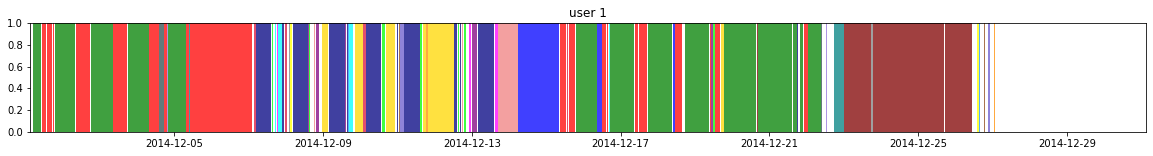

In [27]:
user = '1'
start_datetime = pd.to_datetime('2014-12-01 030000')
end_datetime = pd.to_datetime('2014-12-31 030000')
ax = cstdf.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime)

In [28]:
df_points = cstdf.groupby(['uid', 'cluster']).agg(
    {
         'lat':"mean",    # Sum duration per group
         'lng':"mean"
    }
)
locations = df_points[['lat', 'lng']]
locationlist = locations.values.tolist()

In [29]:
from folium.plugins import MarkerCluster
map2 = folium.Map(location=[38.9, -77.05], zoom_start=6)

marker_cluster = MarkerCluster().add_to(map2)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(marker_cluster)
map2

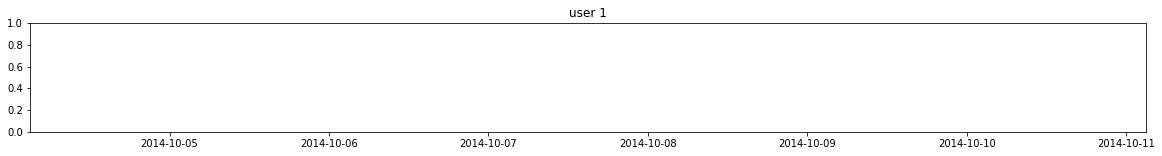

In [30]:
user = '1'
start_datetime = pd.to_datetime('2014-10-04 030000')
end_datetime = pd.to_datetime('2014-10-11 030000')
ax = cstdf.plot_diary(user, start_datetime=start_datetime, end_datetime=end_datetime)

## Split trajectory into daily trajectories

In [31]:
import skmob
from skmob.utils import utils
from skmob.preprocessing import filtering, compression, detection, clustering

In [32]:
# Re-run all the preprocessing operations in one cell

tdf = skmob.TrajDataFrame(df_gps, latitude='Latitude', longitude='Longitude', datetime='Horodate', user_id='ID') 
ftdf = filtering.filter(tdf, max_speed_kmh=400.)
ctdf = compression.compress(ftdf, spatial_radius_km=0.2)
stdf = detection.stops(ctdf, stop_radius_factor=0.5, \
            minutes_for_a_stop=20.0, spatial_radius_km=0.2, leaving_time=True)
cstdf = clustering.cluster(stdf, cluster_radius_km=0.1, min_samples=1)

In [33]:
cstdf

uid                datetime        lat       lng        leaving_datetime  \
0     1 2014-12-01 04:38:09.288  45.770143  4.869833 2014-12-01 09:46:33.934   
1     1 2014-12-01 10:40:09.904  45.786385  4.879803 2014-12-01 11:29:40.936   
2     1 2014-12-01 11:32:56.936  45.786388  4.879777 2014-12-01 13:35:01.937   
3     1 2014-12-01 13:40:46.003  45.786410  4.879838 2014-12-01 17:20:19.714   
4     1 2014-12-01 17:20:19.714  46.336378  6.294770 2014-12-01 17:41:39.286   
..   ..                     ...        ...       ...                     ...   
442   8 2014-12-10 18:38:09.016  44.840073 -0.571013 2014-12-10 22:40:31.022   
443   8 2014-12-10 22:40:31.022  44.841245 -0.573355 2014-12-11 00:08:34.234   
444   8 2014-12-11 00:08:34.234  44.842047 -0.576130 2014-12-11 09:18:57.351   
445   8 2014-12-11 09:29:54.361  44.849782 -0.571265 2014-12-11 15:36:56.766   
446   8 2014-12-11 15:44:34.765  44.842603 -0.575508 2014-12-11 17:09:23.904   

     cluster  
0          1  
1          0  
2          0  
3          0  
4         53  
..       ...  
442        5  
443        4  
444        2  
445        3  
446        2  

[447 rows x 6 columns]

In [34]:
groups = utils.group_df_by_time(cstdf[cstdf['uid'] == '2'], 
                        offset_value=3, offset_unit='hours', add_starting_location=True)
groups[:3]

[  uid                datetime        lat       lng        leaving_datetime  \
 0   2 2014-12-03 16:58:36.260  45.783152  4.878922 2014-12-03 18:39:31.315   
 1   2 2014-12-03 18:57:51.551  45.771386  4.858210 2014-12-03 20:12:27.528   
 2   2 2014-12-03 20:57:46.780  45.783267  4.878908 2014-12-03 22:03:14.818   
 3   2 2014-12-03 22:03:14.818  45.785882  4.878332 2014-12-03 22:54:39.789   
 4   2 2014-12-03 22:54:39.789  45.783277  4.878747 2014-12-04 02:31:28.825   
 5   2 2014-12-04 02:31:28.825  45.779485  4.877368 2014-12-04 03:34:31.795   
 
    cluster  
 0        0  
 1        6  
 2        0  
 3       30  
 4        0  
 5       29  ,
    uid                datetime        lat       lng        leaving_datetime  \
 0    2 2014-12-04 02:31:28.825  45.779485  4.877368 2014-12-04 03:34:31.795   
 1    2 2014-12-04 03:34:31.795  45.783302  4.878947 2014-12-04 09:53:48.009   
 2    2 2014-12-04 09:53:48.009  45.786175  4.879980 2014-12-04 11:02:36.010   
 3    2 2014-12-04 11:06:5

In [35]:
from skmob.measures.individual import home_location

/home/abdelaziz/anaconda3/envs/skmob/lib/python3.7/site-packages/tqdm-4.41.1-py3.7.egg/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [36]:
hl_df = home_location(tdf)
print(hl_df[hl_df["uid"]=="59"])

100%|██████████| 20/20 [00:00<00:00, 65.87it/s]


Empty DataFrame
Columns: [uid, lat, lng]
Index: []


In [37]:
def _work_location_individual(traj, start_day='08:00', end_day='18:00'):
    day_visits = traj.set_index(pd.DatetimeIndex(traj.datetime)).between_time(start_day, end_day)
    if len(day_visits) != 0:
        lat, lng = day_visits.groupby([constants.LATITUDE, constants.LONGITUDE]).count().sort_values(by=constants.DATETIME, ascending=False).iloc[0].name
    else:
        lat, lng = traj.groupby([constants.LATITUDE, constants.LONGITUDE]).count().sort_values(by=constants.DATETIME, ascending=False).iloc[0].name
    work_coords = (lat, lng)
    return work_coords

In [38]:
def work_location(traj, start_day='08:00', end_day='18:00', show_progress=True):
    # if 'uid' column in not present in the TrajDataFrame
    if constants.UID not in traj.columns:
        return pd.DataFrame([_work_location_individual(traj, start_day=start_day, end_day=end_day)], columns=[constants.LATITUDE, constants.LONGITUDE])
    
    if show_progress:
        df = traj.groupby(constants.UID).progress_apply(lambda x: _work_location_individual(x, start_day=start_day, end_day=end_day))
    else:
        df = traj.groupby(constants.UID).apply(lambda x: _work_location_individual(x, start_day=start_day, end_day=end_day))
    return df.apply(pd.Series).reset_index().rename(columns={0: constants.LATITUDE, 1: constants.LONGITUDE})

In [39]:
wl_df = work_location(tdf)
print(wl_df.head())

100%|██████████| 20/20 [00:00<00:00, 61.09it/s]

  uid        lat       lng
0   1  44.515405  4.780835
1  11  45.750283  4.888703
2  13  44.849867 -0.571312
3  14  44.849648 -0.571252
4  15  44.833897 -0.566408


**Visualise the diaries of each sub-trajectory**

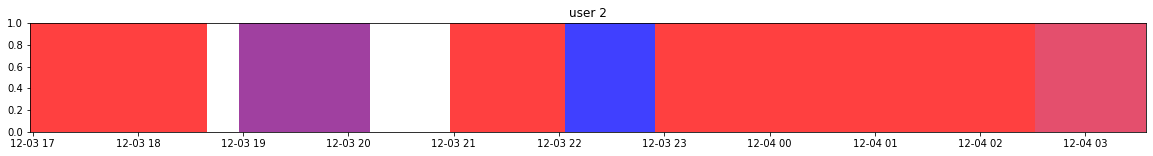

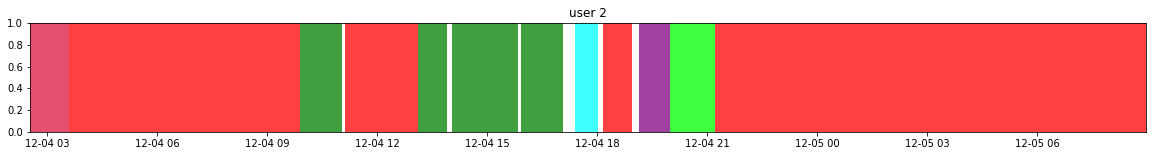

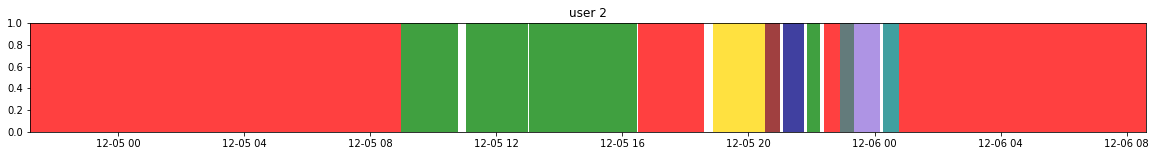

In [40]:
for tdf in groups[:3]:
    user = tdf['uid'].iloc[0]
    ax = tdf.plot_diary(user)

## Routing

Using OSMnx and networkx (taken from https://medium.com/@bobhaffner/osmnx-intro-and-routing-1fd744ba23d8).

In [41]:
import osmnx as ox
import folium

In [42]:
start_i = 0
dt_start = cstdf.iloc[start_i]['leaving_datetime']
dt_end = cstdf.iloc[start_i + 1]['datetime']
user_id = cstdf.iloc[start_i]['uid']

dt_start, dt_end

(Timestamp('2014-12-01 09:46:33.934000'),
 Timestamp('2014-12-01 10:40:09.904000'))

In [43]:
tdf1 = ftdf[(ftdf['datetime'] >= dt_start) & \
            (ftdf['datetime'] <= dt_end) & \
            (ftdf['uid'] == user_id)]
tdf1.plot_trajectory()

## Privacy Risk Assessment

* Simulate privacy attacks and assess risk with a worst-case scenario framework

* First, we import the necessary modules

In [44]:
from skmob.privacy import attacks
from skmob.core.trajectorydataframe import TrajDataFrame
from skmob.utils import constants

In [45]:
# Re-run all the preprocessing operations in one cell
tdf = skmob.TrajDataFrame(df_gps, latitude='Latitude', longitude='Longitude', datetime='Horodate', user_id='ID') 
ftdf = filtering.filter(tdf, max_speed_kmh=300.)
ctdf = compression.compress(ftdf, spatial_radius_km=0.5)
stdf = detection.stops(ctdf, stop_radius_factor=2, \
            minutes_for_a_stop=120.0, spatial_radius_km=1.0, leaving_time=True)
cstdf = clustering.cluster(stdf, cluster_radius_km=1.0, min_samples=1)

In [46]:
cstdf

uid                datetime        lat       lng        leaving_datetime  \
0     1 2014-12-01 04:38:09.288  45.770688  4.865429 2014-12-01 09:59:13.923   
1     1 2014-12-01 10:34:58.969  45.786374  4.879776 2014-12-01 17:20:19.714   
2     1 2014-12-01 18:56:03.328  45.772605  4.870203 2014-12-02 08:01:03.849   
3     1 2014-12-02 08:55:14.322  45.714277  4.917270 2014-12-02 11:41:28.404   
4     1 2014-12-02 11:41:28.404  45.786644  4.879739 2014-12-02 17:25:59.319   
..   ..                     ...        ...       ...                     ...   
140   6 2014-12-27 08:43:45.696  48.948472  2.914889 2014-12-28 09:54:24.799   
141   6 2014-12-28 10:29:47.625  49.071020  2.564377 2014-12-30 08:38:44.148   
142   7 2014-12-01 02:25:23.013  45.186282  5.748243 2014-12-02 06:41:19.434   
143   8 2014-12-01 00:18:42.792  45.189155  5.718502 2014-12-01 07:50:47.805   
144   8 2014-12-01 09:38:57.802  45.779005  4.866862 2014-12-09 10:30:10.558   

     cluster  
0          0  
1          0  
2          0  
3         10  
4          0  
..       ...  
140        1  
141        0  
142        0  
143        1  
144        0  

[145 rows x 6 columns]

In [47]:
at = attacks.LocationAttack(knowledge_length=2)

In [48]:
at.assess_risk(cstdf)

uid  risk
0    1   1.0
1   11   1.0
2   13   1.0
3   14   1.0
4   15   1.0
5   16   1.0
6   17   1.0
7   19   1.0
8    2   1.0
9   20   1.0
10  21   1.0
11  22   1.0
12  23   1.0
13  24   1.0
14  25   1.0
15   5   1.0
16   6   1.0
17   7   1.0
18   8   1.0

In [49]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="OT6-Attack")

N*(N+1)/2 relations

In [50]:
# df[df["cluster"]==14][["lat", "lng"]].loc[df["uid"].isin(['15', '17'])]

In [51]:
# test = df[df["cluster"]==2]#[["lat", "lng"]].loc[df["uid"]=="15"]
# test

In [52]:
# test = test.to_numpy()

In [53]:
# lat15, lng15 = test[0]

In [54]:
# coord = "{}, {}".format(lat15, lng15)
# coord

In [55]:
location = geolocator.reverse("45.7558, 4.8661")
location.raw

{'place_id': 101869946,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 62340578,
 'lat': '45.7552377',
 'lon': '4.866841492509142',
 'display_name': 'Mosquée Es-salem, Rue Baraban, La Villette, Lyon 3e Arrondissement, Lyon, Métropole de Lyon, Circonscription départementale du Rhône, Auvergne-Rhône-Alpes, France métropolitaine, 69001, France',
 'address': {'place_of_worship': 'Mosquée Es-salem',
  'road': 'Rue Baraban',
  'suburb': 'La Villette',
  'city_district': 'Lyon 3e Arrondissement',
  'city': 'Lyon',
  'county': 'Lyon',
  'state_district': 'Circonscription départementale du Rhône',
  'state': 'Auvergne-Rhône-Alpes',
  'country': 'France',
  'postcode': '69001',
  'country_code': 'fr'},
 'boundingbox': ['45.7551943', '45.7552975', '4.8667593', '4.8669285']}

In [56]:
# typePlace = list(location.raw["address"].keys())[0]
# typePlace

In [57]:
#relationShip = {"house_number": "family", "bus_stop": "friends, road buddies, colleagues"}colleagues

In [58]:
df = df[df["cluster"]!=-1]
clusters = set(df["cluster"])
clusters

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21}

In [59]:
df

uid                datetime        lat       lng  \
10    1 2014-12-03 08:19:32.049  45.785517  4.879468   
20    1 2014-12-05 08:39:41.747  45.786565  4.879857   
146  11 2014-12-10 12:39:08.575  44.849648 -0.571302   
151  11 2014-12-11 18:12:41.279  45.010965 -0.644268   
169  13 2014-12-09 17:10:19.171  44.834477 -0.563345   
..   ..                     ...        ...       ...   
375   8 2014-12-09 17:38:14.069  44.834647 -0.564653   
376   8 2014-12-09 22:21:17.240  44.836245 -0.567592   
377   8 2014-12-10 00:38:45.236  44.842029 -0.576345   
378   8 2014-12-10 17:27:40.946  44.838152 -0.578636   
379   8 2014-12-10 18:38:09.016  44.840073 -0.571013   

               leaving_datetime  cluster  
10   2014-12-03 09:39:42.997000        1  
20   2014-12-05 09:45:18.795000        2  
146  2014-12-10 19:15:58.341000        3  
151  2014-12-12 05:31:45.029000        4  
169  2014-12-09 22:10:57.477000        5  
..                          ...      ...  
375  2014-12-09 22:21:17.240000        5  
376  2014-12-10 00:19:27.246000       18  
377  2014-12-10 17:27:40.946000       19  
378  2014-12-10 18:26:48.026000       13  
379  2014-12-10 22:40:31.022000       14  

[71 rows x 6 columns]

In [60]:
meanData = []
for i in range(1, len(clusters)+1):
    latLngDate = df[df["cluster"]==i][["lat", "lng"]].to_numpy()#.loc[df["uid"].isin(['15', '17'])]
    toAdd = list(np.mean(latLngDate, axis=0))
    toAdd.append(df[df["cluster"]==i]["datetime"].iloc[0])
    toAdd.append(df[df["cluster"]==i]["leaving_datetime"].iloc[0])
    toAdd.insert(0, i)
    meanData.append(toAdd)
meanData = np.array(meanData)

In [61]:
dataset = pd.DataFrame({"uid": meanData[:, 0], 'lat': meanData[:, 1], 'lng': meanData[:, 2], 'datetime': meanData[:, 3], 'leaving_datetime': meanData[:, 4]})
dataset

uid      lat       lng                datetime        leaving_datetime
0    1   45.786   4.87967 2014-12-03 08:19:32.049 2014-12-03 09:39:42.997
1    2  45.7863   4.88018 2014-12-05 08:39:41.747 2014-12-05 09:45:18.795
2    3  44.8496  -0.57149 2014-12-10 12:39:08.575 2014-12-10 19:15:58.341
3    4  45.0111 -0.643993 2014-12-11 18:12:41.279 2014-12-12 05:31:45.029
4    5  44.8344 -0.563569 2014-12-09 17:10:19.171 2014-12-09 22:10:57.477
5    6  45.7819   4.87277 2014-12-05 16:45:30.661 2014-12-08 16:44:27.849
6    7  44.8551 -0.566913 2014-12-08 16:49:21.641 2014-12-08 17:53:35.641
7    8  44.8434 -0.575268 2014-12-08 18:08:00.641 2014-12-08 19:46:11.927
8    9  44.8413 -0.572933 2014-12-08 19:46:11.927 2014-12-08 23:15:58.901
9   10  44.8499  -0.57096 2014-12-09 07:41:34.456 2014-12-09 16:43:29.918
10  11  44.8553  -0.56647 2014-12-10 04:12:38.051 2014-12-10 07:38:09.907
11  12  44.8498  -0.57107 2014-12-10 07:42:29.907 2014-12-10 13:55:38.322
12  13   44.838  -0.57858 2014-12-10 17:27:01.752 2014-12-10 18:35:41.378
13  14  44.8403 -0.571963 2014-12-10 18:47:27.374 2014-12-10 21:27:58.374
14  15  44.8553 -0.566505 2014-12-11 23:40:50.936 2014-12-12 07:41:51.956
15  16  45.7865   4.87996 2014-12-05 12:51:50.855 2014-12-05 16:43:54.828
16  17  45.7866   4.87988 2014-12-05 15:56:55.500 2014-12-05 16:43:55.500
17  18  44.8359 -0.567552 2014-12-09 22:21:57.713 2014-12-10 00:16:30.730
18  19   44.842 -0.576293 2014-12-10 00:36:12.730 2014-12-10 07:28:53.734
19  20  44.8497 -0.571596 2014-12-10 09:23:14.407 2014-12-10 17:18:43.647
20  21  44.8429 -0.574886 2014-12-10 18:35:33.648 2014-12-10 22:22:47.670

In [62]:
dd = skmob.TrajDataFrame(dataset, latitude=1, longitude=2, datetime=3)
dd

uid        lat       lng                datetime        leaving_datetime
0    1  45.785984  4.879672 2014-12-03 08:19:32.049 2014-12-03 09:39:42.997
1    2  45.786327  4.880184 2014-12-05 08:39:41.747 2014-12-05 09:45:18.795
2    3  44.849637 -0.571490 2014-12-10 12:39:08.575 2014-12-10 19:15:58.341
3    4  45.011079 -0.643993 2014-12-11 18:12:41.279 2014-12-12 05:31:45.029
4    5  44.834380 -0.563569 2014-12-09 17:10:19.171 2014-12-09 22:10:57.477
5    6  45.781916  4.872766 2014-12-05 16:45:30.661 2014-12-08 16:44:27.849
6    7  44.855088 -0.566913 2014-12-08 16:49:21.641 2014-12-08 17:53:35.641
7    8  44.843427 -0.575268 2014-12-08 18:08:00.641 2014-12-08 19:46:11.927
8    9  44.841293 -0.572933 2014-12-08 19:46:11.927 2014-12-08 23:15:58.901
9   10  44.849933 -0.570960 2014-12-09 07:41:34.456 2014-12-09 16:43:29.918
10  11  44.855320 -0.566470 2014-12-10 04:12:38.051 2014-12-10 07:38:09.907
11  12  44.849805 -0.571070 2014-12-10 07:42:29.907 2014-12-10 13:55:38.322
12  13  44.838040 -0.578580 2014-12-10 17:27:01.752 2014-12-10 18:35:41.378
13  14  44.840320 -0.571963 2014-12-10 18:47:27.374 2014-12-10 21:27:58.374
14  15  44.855320 -0.566505 2014-12-11 23:40:50.936 2014-12-12 07:41:51.956
15  16  45.786509  4.879960 2014-12-05 12:51:50.855 2014-12-05 16:43:54.828
16  17  45.786644  4.879880 2014-12-05 15:56:55.500 2014-12-05 16:43:55.500
17  18  44.835892 -0.567552 2014-12-09 22:21:57.713 2014-12-10 00:16:30.730
18  19  44.842050 -0.576293 2014-12-10 00:36:12.730 2014-12-10 07:28:53.734
19  20  44.849744 -0.571596 2014-12-10 09:23:14.407 2014-12-10 17:18:43.647
20  21  44.842892 -0.574886 2014-12-10 18:35:33.648 2014-12-10 22:22:47.670

In [63]:
map_f = dd.plot_trajectory(max_points=1, hex_color=-1, start_end_markers=False)
dd.plot_stops(map_f=map_f, hex_color=-1)

In [77]:
places = []
name = []
address = []
for i in range(1, len(clusters)+1):
    test = dataset[dataset["uid"]==i][["lat", "lng"]]
    test = test.to_numpy()
    lat, lng = test[0]
    coord = "{}, {}".format(lat, lng)
    location = geolocator.reverse(coord)
    places.append(list(location.raw["address"].keys())[0])
    name.append(list(location.raw["address"].values())[0])
    address.append(location.raw["display_name"])
places

['college',
 'college',
 'building',
 'village',
 'restaurant',
 'address29',
 'house_number',
 'pedestrian',
 'restaurant',
 'house_number',
 'house_number',
 'house_number',
 'cafe',
 'restaurant',
 'house_number',
 'college',
 'college',
 'bank',
 'information',
 'building',
 'footway']

In [78]:
name

['Institut National des Sciences Appliquées de Lyon',
 'Institut National des Sciences Appliquées de Lyon',
 'Cité Mondiale',
 'Labarde',
 'Sabor Y Son',
 'Blaise Pascal',
 '10',
 'Allées de Tourny',
 'La Casuccia',
 '6',
 '12',
 '6',
 'Le Café Rohan',
 'La Fromentine',
 '13',
 'Institut National des Sciences Appliquées de Lyon',
 'Institut National des Sciences Appliquées de Lyon',
 'BNP Paribas',
 'Maison du Tourisme de la Gironde',
 'Cité Mondiale',
 'Allées de Tourny']

In [79]:
address

['Institut National des Sciences Appliquées de Lyon, 20, Avenue Albert Einstein, Croix-Luizet, Villeurbanne, Lyon, Métropole de Lyon, Circonscription départementale du Rhône, Auvergne-Rhône-Alpes, France métropolitaine, 69100, France',
 'Institut National des Sciences Appliquées de Lyon, 20, Avenue Albert Einstein, Croix-Luizet, Villeurbanne, Lyon, Métropole de Lyon, Circonscription départementale du Rhône, Auvergne-Rhône-Alpes, France métropolitaine, 69100, France',
 'Cité Mondiale, Passage Notre-Dame, Chartrons - Grand Parc - Jardin Public, Bordeaux, Gironde, Nouvelle-Aquitaine, France métropolitaine, 33000, France',
 'Labarde, Lesparre-Médoc, Gironde, Nouvelle-Aquitaine, France métropolitaine, 33460, France',
 'Sabor Y Son, 7, Quai de la Monnaie, Le Parc de Richelieu, Bordeaux Sud, Bordeaux, Gironde, Nouvelle-Aquitaine, France métropolitaine, 33800, France',
 'Blaise Pascal, Rue de la Physique, Croix-Luizet, Villeurbanne, Lyon, Métropole de Lyon, Circonscription départementale du Rh